Ref:

https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

https://www.kaggle.com/code/sunaysawant/air-passengers-time-series-arima/notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

### Data

Reference: https://www.kaggle.com/datasets/rakannimer/air-passengers

This dataset contains the number of air travel passengers per month from the start of 1949 to the end of 1960.

In [2]:
df_orig = pd.read_csv('data/AirPassengers.csv')
df_orig

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df_orig = pd.read_csv('data/AirPassengers.csv')
df_orig['Passengers'] = df_orig['Passengers'].astype(int)
df_orig['Month'] = pd.to_datetime(df_orig['Month'], infer_datetime_format=True)
df = df_orig.copy()
df = df.set_index(['Month'])
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


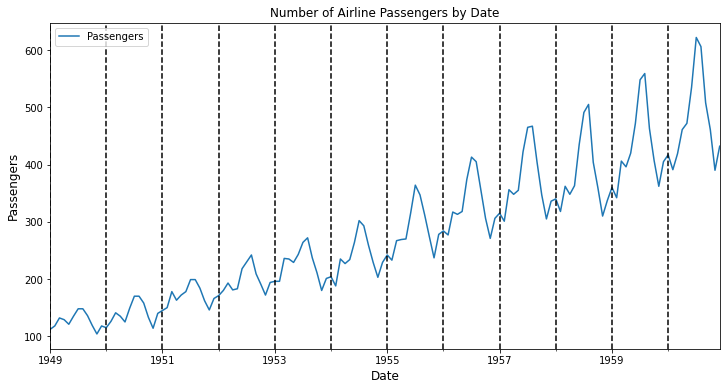

In [4]:
df_orig.plot(x='Month', y='Passengers', figsize=(12,6))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
for i in range(12):
    plt.axvline(x=f'{str(1949+i)}-01-01', color='black', linestyle='--')
plt.show()

**Rolling Statistics**:

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

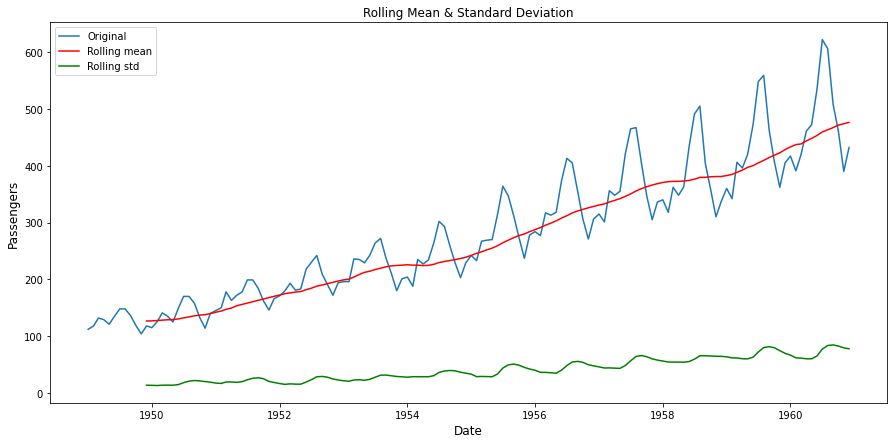

In [5]:
plt.figure(figsize=(15,7))
plt.plot(df["Passengers"], label='Original')
plt.plot(df["Passengers"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df["Passengers"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

**Augmented Dickey–Fuller Test**

In [6]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


**Seasonal decompose**

In [8]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

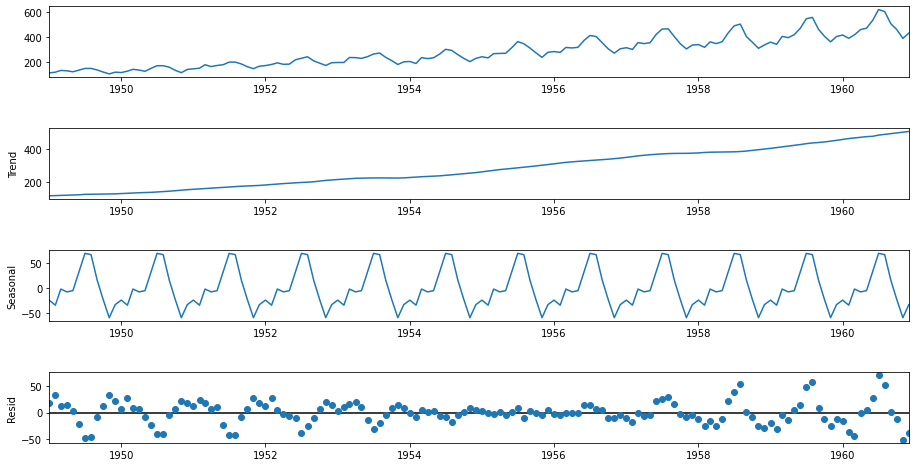

In [9]:
trend, seasonal, residual = seasonal_decompose(df)

## Dividing the data in training and test sets

In [10]:
train_data = df[:int(len(df)*0.8)]
test_data = df[int(len(df)*0.8):]

## Finding the value of the d parameter 

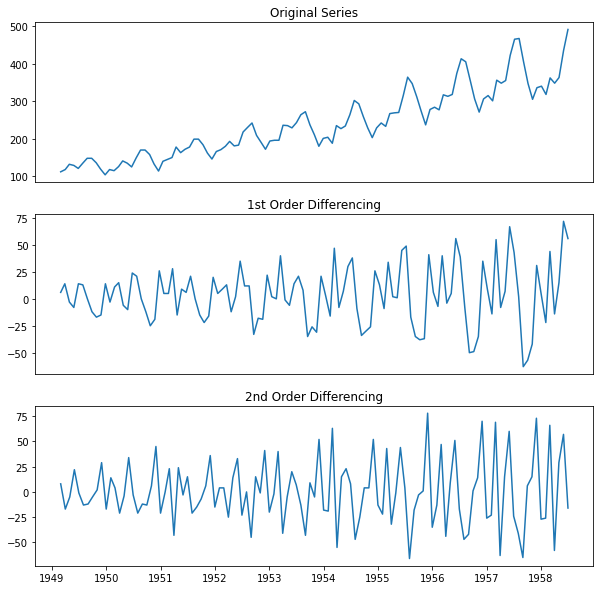

In [11]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data.Passengers)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.Passengers.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.Passengers.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

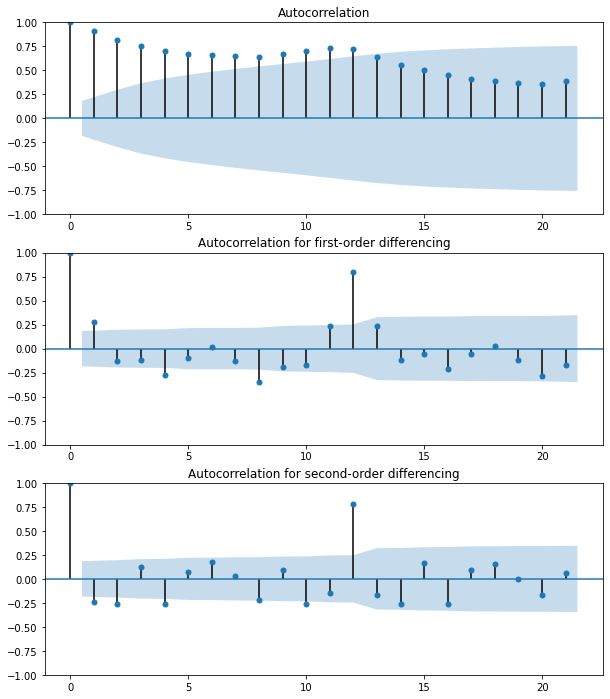

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data.Passengers, ax=ax1)
_ = plot_acf(train_data.Passengers.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.Passengers.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

## Finding the value of the p parameter

/Users/javier.fernandez/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


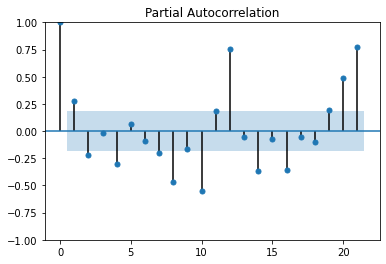

In [13]:
_ = plot_pacf(train_data.Passengers.diff().dropna())

Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1. 

## Finding the value of the q parameter

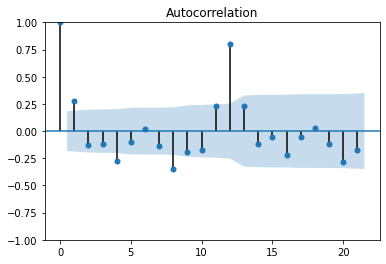

In [14]:
_ = plot_acf(train_data.Passengers.diff().dropna())

## Auto ARIMA library

In [15]:
ARIMA_model = pm.auto_arima(train_data, m=12)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Sun, 03 Jul 2022   AIC                            755.499
Time:                                    16:34:34   BIC                            760.749
Sample:                                         0   HQIC                           757.625
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2        92.6974     13.326      6.956      0.000      66.579     118.816
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""